# Modell für Eingabemaske zur Ermiettlung der Mietpreise durch Referenzmieten

### Daten aufbereiten

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import RootMeanSquaredError
import joblib
import json
import numpy as np
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import warnings
warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
warnings.filterwarnings('ignore', 'sindex.nearest', FutureWarning)
from sklearn.neighbors import KDTree
from tqdm import tqdm

# Load the data
with open("training_Data_Ref_Rent_Model.json", "r") as file: 
    data = json.load(file)

filtered_data = []
for entry in data:
    if 'livingSpace' in entry and 'rent' in entry:
        filtered_data.append(entry)

df = pd.DataFrame(filtered_data)
df['quadratmeterpreis'] = df['rent'] / df['livingSpace']

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
gdf_sindex = gdf.sindex

bool_columns = ["hasBasement", "hasBalcony", "hasGarden", "hasElevator"]
for column in bool_columns:
    df[column] = df[column].map({True: 1, False: 0, np.nan: 0.5})

df["houseType"] = df["houseType"].astype("category").cat.codes
df["quadratmeterpreis"] = df["rent"] / df["livingSpace"]
df = df.dropna(subset=['rent', 'livingSpace'])

# Erstellen Sie ein Array mit den Punkt-Koordinaten
coords = gdf[['Longitude', 'Latitude']].values

# Erstellen Sie eine KDTree
tree = KDTree(coords)

def find_nearby(row, gdf, tree, radius=0.01):
    # Die query-Methode der KDTree gibt einen Abstand und den Index des nächsten Punkts zurück
    indices = tree.query_radius(row[['Longitude', 'Latitude']].values.reshape(1, -1), r=radius)
    indices = indices[0]  # Die Ausgabe ist ein Array von Arrays, wir brauchen nur das erste Array
    potential_matches = gdf.iloc[indices]
    precise_matches = potential_matches[potential_matches.distance(row['geometry']) <= radius]
    if len(precise_matches) < 10:
        _, indices = tree.query(row[['Longitude', 'Latitude']].values.reshape(1, -1), k=10)
        precise_matches = gdf.iloc[indices[0]]
    desc = precise_matches['quadratmeterpreis'].describe().drop(['25%', '50%', '75%'])
    desc.index = ['count_nearby', 'mean_rent_per_sqm_nearby', 'std_rent_per_sqm_nearby', 
              'min_rent_per_sqm_nearby', 'max_rent_per_sqm_nearby']

    # Additional nearby features
    for feature in ["hasBasement", "hasBalcony", "hasGarden", "hasElevator"]:
        desc[f'mean_{feature}_nearby'] = precise_matches[feature].mean()
    
    return desc

original_index = df.index
df = df.reset_index(drop=True)
gdf = gdf.reset_index(drop=True)
df = pd.merge(df, gdf[['geometry']], left_index=True, right_index=True)

results = []
for _, row in tqdm(df.iterrows(), total=df.shape[0]):
    try:
        results.append(find_nearby(row, gdf, tree))
    except RuntimeError: # Sie könnten hier den spezifischen Fehlertyp angeben, der auftritt
        print("Fehler bei Zeile: ", _) 
        continue

#New Dataframe
df_nearby_features = pd.DataFrame(results, columns=['count_nearby', 'mean_rent_per_sqm_nearby', 'std_rent_per_sqm_nearby', 
                                                    'min_rent_per_sqm_nearby', 'max_rent_per_sqm_nearby', 'mean_hasBasement_nearby',
                                                    'mean_hasBalcony_nearby', 'mean_hasGarden_nearby', 'mean_hasElevator_nearby'])

df_nearby_features.index = original_index
df = pd.concat([df, df_nearby_features], axis=1)
df = df.drop(columns=['geometry'])

# Remove unwanted columns from X
X = df.drop(columns=["rent", "address", "Latitude", "Longitude", "stadt", "stadtteil", "plz", "strasse", "bundesland", "quadratmeterpreis","year"])
y = df["quadratmeterpreis"]

# Fill NaN values in X with the mean value of the respective column
X = X.fillna(X.mean())
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.mean(), inplace=True)
y = y.loc[X.index]

# Preprocessing and splitting into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Save the training data
train_data = pd.concat([pd.DataFrame(X_train), pd.Series(y_train)], axis=1)
train_data.to_csv('train_data.csv', index=False)

# Save the test data
test_data = pd.concat([pd.DataFrame(X_test), pd.Series(y_test)], axis=1)
test_data.to_csv('test_data.csv', index=False)

# Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# To save
joblib.dump(scaler, 'scaler1.pkl')


100%|██████████| 137260/137260 [1:23:41<00:00, 27.34it/s]  


['scaler1.pkl']

### Modell trainieren und speichern

C:\Users\Joel\AppData\Local\Temp\ipykernel_23676\97558482.py:18: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  train_data = train_data[~train_data.isin([np.inf, -np.inf]).any(1)]
C:\Users\Joel\AppData\Local\Temp\ipykernel_23676\97558482.py:24: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  test_data = test_data[~test_data.isin([np.inf, -np.inf]).any(1)]


Epoch 1/6
3646/3646 [==============================] - 29s 7ms/step - loss: 24.1532 - root_mean_squared_error: 4.9146 - val_loss: 15.6541 - val_root_mean_squared_error: 3.9565
Epoch 2/6
3646/3646 [==============================] - 31s 8ms/step - loss: 19.3061 - root_mean_squared_error: 4.3939 - val_loss: 16.1650 - val_root_mean_squared_error: 4.0206
Epoch 3/6
3646/3646 [==============================] - 34s 9ms/step - loss: 18.8242 - root_mean_squared_error: 4.3387 - val_loss: 15.0095 - val_root_mean_squared_error: 3.8742
Epoch 4/6
3646/3646 [==============================] - 33s 9ms/step - loss: 18.9108 - root_mean_squared_error: 4.3487 - val_loss: 15.1203 - val_root_mean_squared_error: 3.8885
Epoch 5/6
3646/3646 [==============================] - 34s 9ms/step - loss: 18.5920 - root_mean_squared_error: 4.3118 - val_loss: 14.7575 - val_root_mean_squared_error: 3.8416
Epoch 6/6
644/644 [==============================] - 3s 5ms/step
Percentage of NaN values in y_pred: 0.00%
RMSE per sqm 

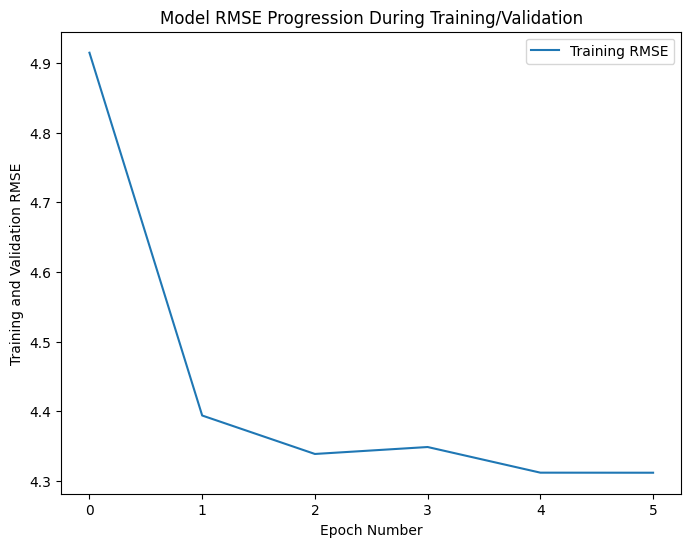

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import matplotlib.pyplot as plt

# Einlesen der Trainings- und Testdaten
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

# Entfernen von Zeilen mit 'inf'-Werten aus train_data
train_data = train_data[~train_data.isin([np.inf, -np.inf]).any(1)]

# Entfernen von Zeilen mit NaN-Werten aus train_data
train_data = train_data.dropna()

# Entfernen von Zeilen mit 'inf'-Werten aus test_data
test_data = test_data[~test_data.isin([np.inf, -np.inf]).any(1)]

# Entfernen von Zeilen mit NaN-Werten aus test_data
test_data = test_data.dropna()

# Trennung von Features (X) und Labels (y) für Trainingsdaten
X_train = train_data.drop(['quadratmeterpreis'], axis=1)
y_train = train_data['quadratmeterpreis']

# Trennung von Features (X) und Labels (y) für Testdaten
X_test = test_data.drop(['quadratmeterpreis'], axis=1)
y_test = test_data['quadratmeterpreis']

# Laden Sie den Skaler
scaler = joblib.load('scaler1.pkl')

# Skalieren Sie die Trainings- und Testdaten
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Modelldefinition
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

# Modellkompilierung
optimizer = Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[RootMeanSquaredError()])

# Frühzeitiges Beenden des Trainings, wenn keine Verbesserung mehr stattfindet
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Modellanpassung mit Überwachung der Metriken und Early Stopping
history = model.fit(X_train, y_train, epochs=6, batch_size=32, verbose=1,
                    validation_data=(X_test, y_test), callbacks=[early_stopping])

# Vorhersagen für Testdaten
y_pred = model.predict(X_test).flatten()

# Berechnung des Prozentsatzes der NaN-Werte in y_pred
nan_percentage = (np.isnan(y_pred).sum() / len(y_pred)) * 100
print("Percentage of NaN values in y_pred: %.2f%%" % nan_percentage)

# Falls es keine Nicht-NaN Werte gibt, beenden wir hier
if nan_percentage == 100:
    print("All predictions are NaN. Please check the model.")
else:
    # Entfernen von NaN-Werten aus y_pred und y_test
    valid_indices = ~np.isnan(y_pred)
    y_pred_no_nan = y_pred[valid_indices]
    y_test_no_nan = np.array(y_test)[valid_indices]

    # Berechnung des RMSE für nicht-NaN-Werte
    rmse_no_nan = np.sqrt(mean_squared_error(y_test_no_nan, y_pred_no_nan))
    print("RMSE per sqm (without NaN values): %f" % (rmse_no_nan))

# Modell speichern
model.save('rent_per_sqm_model_nn.h5')

# Anzeige der Verlaufskurve des RMSE während des Trainings
plt.figure(figsize=(8,6))
plt.plot(history.history['root_mean_squared_error'])
plt.title('Model RMSE Progression During Training/Validation')
plt.ylabel('Training and Validation RMSE')
plt.xlabel('Epoch Number')
plt.legend(['Training RMSE', 'Validation RMSE'])
plt.show()

### Visualisierung

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.


32/32 [==============================] - 0s 2ms/step


Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

65125/65125 [==============================] - 163s 2ms/step


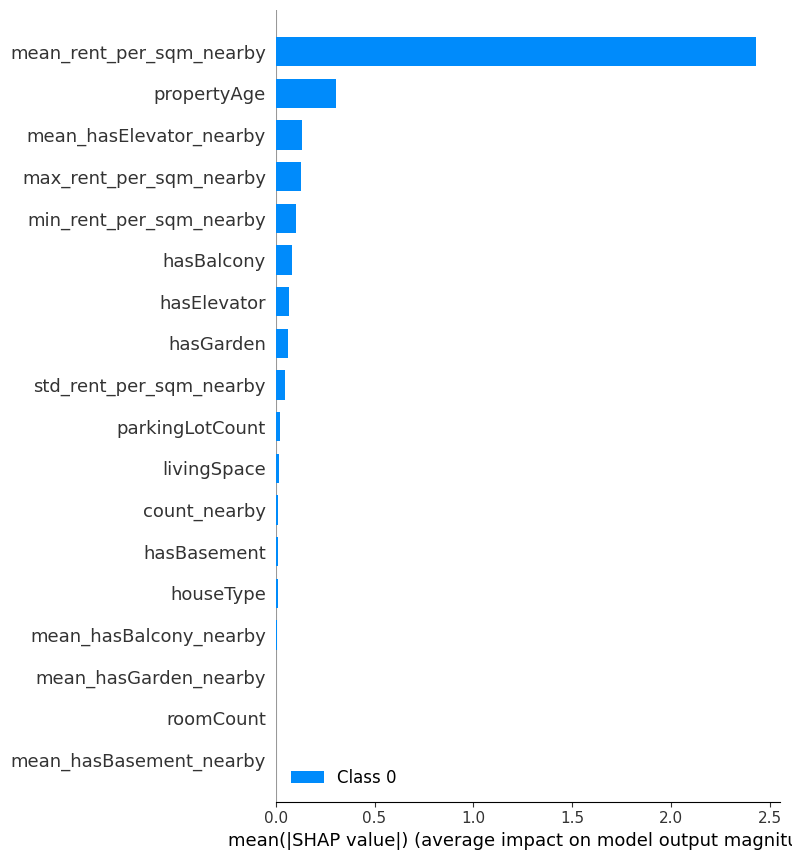

In [3]:
# Importing required packages
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import joblib
from tensorflow.keras.models import load_model
import shap

# Load scaler
scaler = joblib.load('scaler1.pkl')

# Load model
model = load_model('rent_per_sqm_model_nn.h5')

# Load the test data
test_data = pd.read_csv('test_data.csv')

# Remove rows with 'inf' values from test_data
test_data = test_data[~test_data.isin([np.inf, -np.inf]).any(1)]

# Remove rows with NaN values from test_data
test_data = test_data.dropna()

# Split features (X) and labels (y) for test data
X_test = test_data.drop(['quadratmeterpreis'], axis=1)

# Scale the test data
X_test = scaler.transform(X_test)

# Use the first 1000 samples to avoid long computation time
background = X_test[:1000]

# Initialize JS for SHAP
shap.initjs()

# Use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(model.predict, background)
# Your previous code remains the same...

# Extract feature names after dropping the target
feature_names = test_data.drop(['quadratmeterpreis'], axis=1).columns

# Compute the SHAP values for a single prediction
shap_values = explainer.shap_values(X_test[:1])

plt.figure(figsize=(6, 4)) # Adjust the size as needed.
shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type="bar")
plt.show()
